In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-sales-forecast/features.csv
/kaggle/input/walmart-sales-forecast/stores.csv
/kaggle/input/walmart-sales-forecast/train.csv
/kaggle/input/walmart-sales-forecast/test.csv


Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


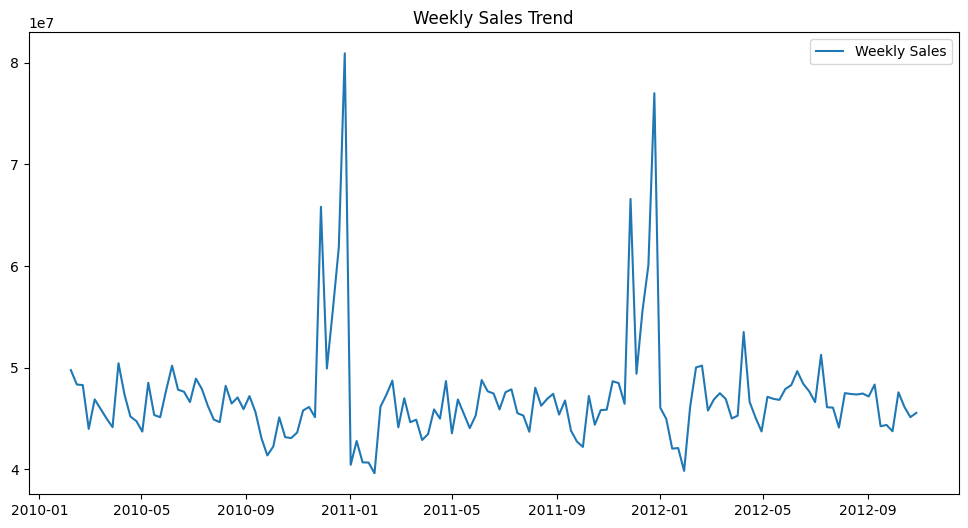

In [2]:


# Load dataset
df = pd.read_csv("/kaggle/input/walmart-sales-forecast/train.csv")  # Change filename if needed

# Convert 'Date' to datetime format & set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Check for missing values
print(df.isnull().sum())

# Resample to weekly sales trends
weekly_sales = df.resample('W').sum()

# Plot initial trend
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['Weekly_Sales'], label="Weekly Sales")
plt.title("Weekly Sales Trend")
plt.legend()
plt.show()


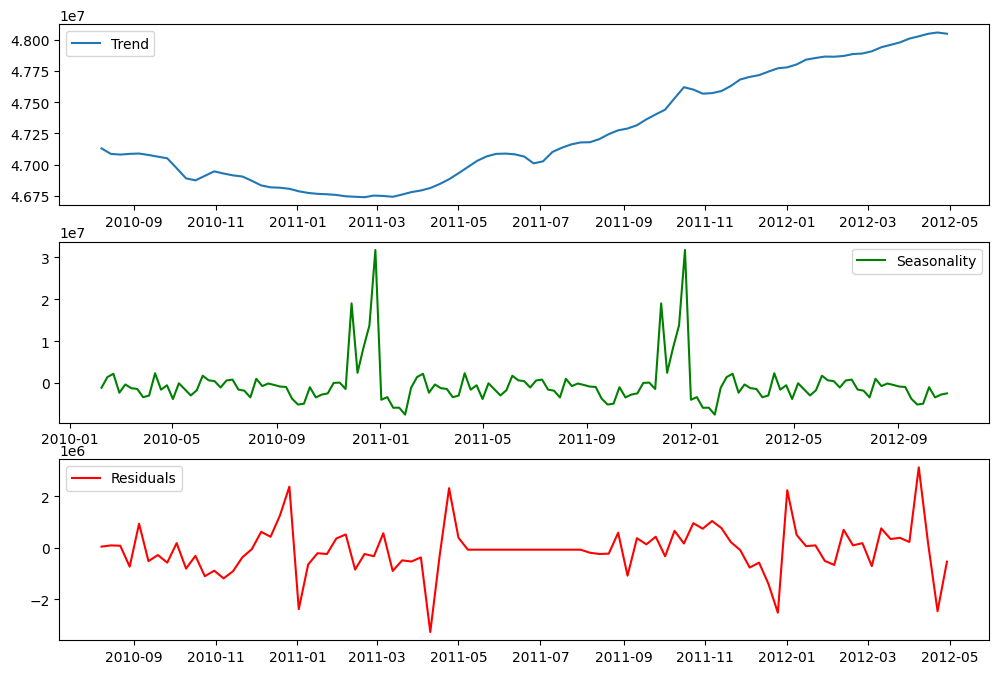

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposition = seasonal_decompose(weekly_sales['Weekly_Sales'], model='additive')

# Plot decomposition
plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(decomposition.trend, label="Trend")
plt.legend()

plt.subplot(3,1,2)
plt.plot(decomposition.seasonal, label="Seasonality", color='green')
plt.legend()

plt.subplot(3,1,3)
plt.plot(decomposition.resid, label="Residuals", color='red')
plt.legend()

plt.show()


In [20]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
result = adfuller(weekly_sales['Weekly_Sales'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

# If p-value > 0.05, data is non-stationary, so we need differencing.


ADF Statistic: -5.908297957186334
p-value: 2.675979158986027e-07


In [22]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(weekly_sales['Weekly_Sales'], 
                        order=(1,0,1),   # Set d=0
                        seasonal_order=(1,0,1,52),  # Set D=0
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarima_fit = sarima_model.fit()

print(sarima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -1470.357
Date:                            Tue, 18 Feb 2025   AIC                           2950.713
Time:                                    23:08:54   BIC                           2963.156
Sample:                                02-07-2010   HQIC                          2955.729
                                     - 10-28-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9846      0.138      7.153      0.000       0.715       1.254
ma.L1         -0.3643      0.499   

In [23]:
# Forecast next 12 weeks
forecast_steps = 12
forecast = sarima_fit.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_index = pd.date_range(start=weekly_sales.index[-1], periods=forecast_steps+1, freq='W')[1:]
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Get actual sales for the last 12 weeks
actual_sales = weekly_sales['Weekly_Sales'][-forecast_steps:]

# Compute MAE & RMSE
mae = mean_absolute_error(actual_sales, forecast_values)
rmse = np.sqrt(mean_squared_error(actual_sales, forecast_values))

# Print results
print(f"Optimized SARIMA - MAE: {mae:,.2f}, RMSE: {rmse:,.2f}")


Optimized SARIMA - MAE: 6,679,040.24, RMSE: 10,306,289.43


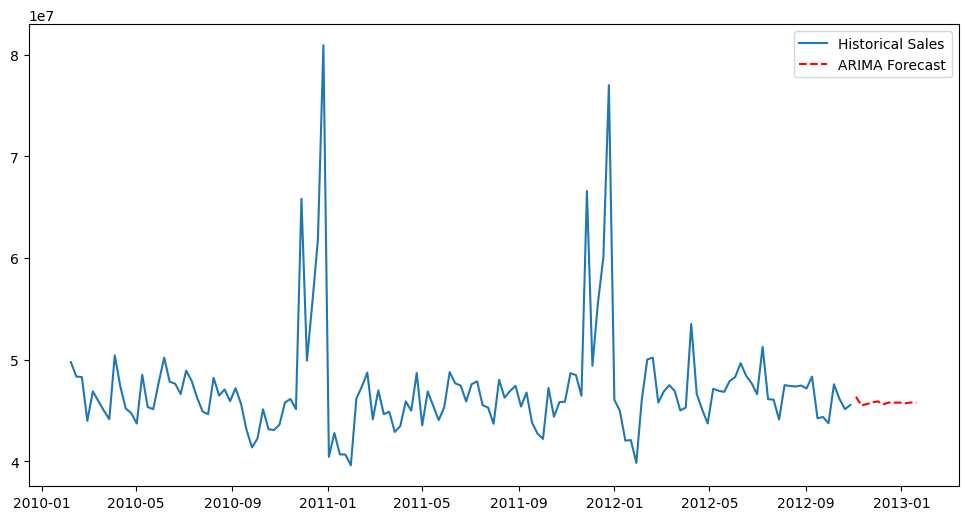

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA Model
arima_model = ARIMA(weekly_sales['Weekly_Sales'], order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast next 12 weeks
forecast_arima = arima_fit.forecast(steps=12)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(weekly_sales['Weekly_Sales'], label="Historical Sales")
plt.plot(forecast_arima, label="ARIMA Forecast", linestyle="dashed", color='red')
plt.legend()
plt.show()


In [6]:
!pip install prophet


22:30:29 - cmdstanpy - INFO - Chain [1] start processing
22:30:29 - cmdstanpy - INFO - Chain [1] done processing


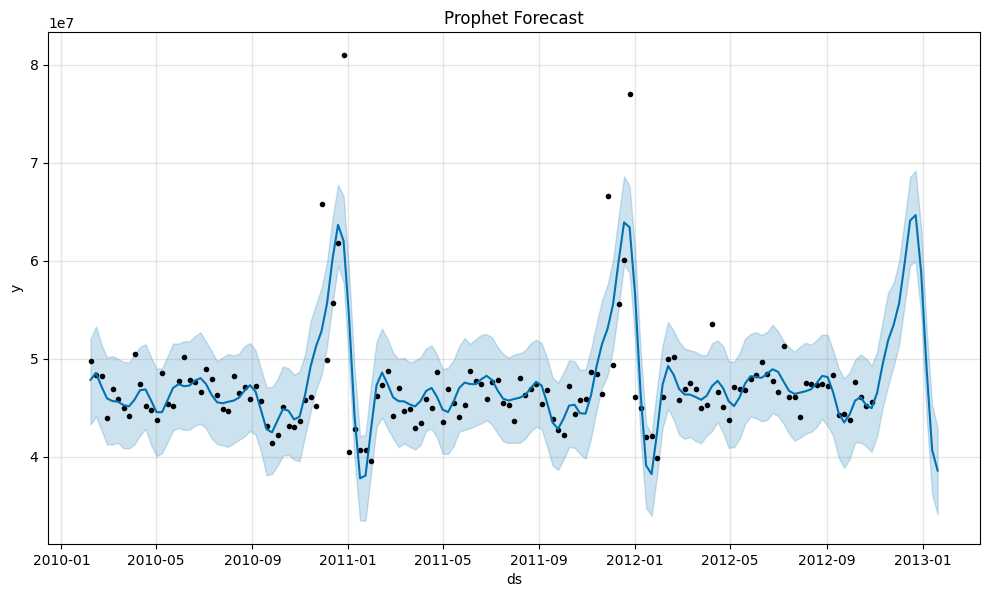

In [16]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = weekly_sales.reset_index()
df_prophet = df_prophet.rename(columns={"Date": "ds", "Weekly_Sales": "y"})


# # Train Prophet Model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# # Create future dates
future = prophet_model.make_future_dataframe(periods=12, freq='W')

# # Forecast
forecast_prophet = prophet_model.predict(future)

# # Plot forecast
prophet_model.plot(forecast_prophet)
plt.title("Prophet Forecast")
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate ARIMA
mae_arima = mean_absolute_error(weekly_sales['Weekly_Sales'][-12:], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(weekly_sales['Weekly_Sales'][-12:], forecast_arima))

# Evaluate Prophet
forecast_prophet_actual = forecast_prophet.set_index('ds')['yhat'][-12:]
mae_prophet = mean_absolute_error(weekly_sales['Weekly_Sales'][-12:], forecast_prophet_actual)
rmse_prophet = np.sqrt(mean_squared_error(weekly_sales['Weekly_Sales'][-12:], forecast_prophet_actual))

print(f"ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}")
print(f"Prophet - MAE: {mae_prophet}, RMSE: {rmse_prophet}")


ARIMA - MAE: 1372487.411247962, RMSE: 1519070.8153991017
Prophet - MAE: 8554084.134396812, RMSE: 10757721.458795855


In [18]:
# Save predictions to CSV
forecast_prophet[['ds', 'yhat']].to_csv("walmart_forecast.csv", index=False)


In [19]:
forecast_prophet[['ds', 'yhat']]

,ds,yhat
0,2010-02-07,4.783822e+07
1,2010-02-14,4.854189e+07
2,2010-02-21,4.715907e+07
3,2010-02-28,4.594352e+07
4,2010-03-07,4.566779e+07
...,...,...
150,2012-12-23,6.464310e+07
151,2012-12-30,5.885525e+07
152,2013-01-06,4.893308e+07
153,2013-01-13,4.066294e+07


In [11]:
print(df.columns)
print(df.shape)  # Check number of columns


Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday'], dtype='object')
(421570, 4)
